<a href="https://colab.research.google.com/github/jpan0829/MultipleObjectTracking/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 95% 114M/121M [00:03<00:00, 30.8MB/s]
100% 121M/121M [00:03<00:00, 39.2MB/s]


In [ ]:
!unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import SGD,RMSprop
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
path='images/'

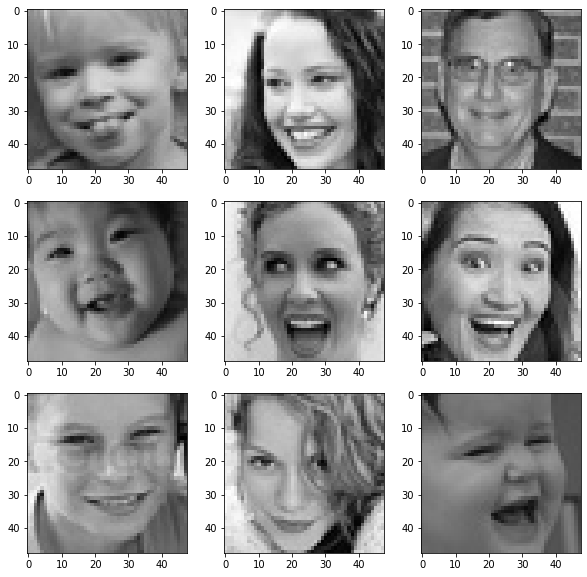

In [ ]:
expression = 'happy'

plt.figure(figsize= (10,10))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(path+"train/"+expression+"/"+
                  os.listdir(path + "train/" + expression)[i])
    plt.imshow(img)
plt.show()


In [ ]:
batch_size  = 128
picture_size = 48

gen_train  = ImageDataGenerator()
gen_val = ImageDataGenerator()

train = gen_train.flow_from_directory(path+"train",
                                       target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical')

val = gen_val.flow_from_directory(path+"validation",
                                    target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical')


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_35 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_35 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 24, 24, 128)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint = ModelCheckpoint("./model.cnn", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#early_stopping = EarlyStopping(monitor='val_loss',
                          #min_delta=0,
                          #patience=5,
                          #verbose=1,
                          #restore_best_weights=True
                          #)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint,reduce_learningrate]


model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
epochs = 50
process = model.fit_generator(generator=train,
                                steps_per_epoch=train.n//train.batch_size,
                                epochs=epochs,
                                validation_data = val,
                                validation_steps = val.n//val.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.7955 - accuracy: 0.3059
Epoch 00001: val_accuracy improved from -inf to 0.33111, saving model to ./model.cnn
INFO:tensorflow:Assets written to: ./model.cnn/assets
225/225 [==============================] - 15s 59ms/step - loss: 1.7955 - accuracy: 0.3059 - val_loss: 1.8127 - val_accuracy: 0.3311 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.4373 - accuracy: 0.4465
Epoch 00002: val_accuracy improved from 0.33111 to 0.46392, saving model to ./model.cnn
INFO:tensorflow:Assets written to: ./model.cnn/assets
225/225 [==============================] - 13s 59ms/step - loss: 1.4373 - accuracy: 0.4465 - val_loss: 1.5364 - val_accuracy: 0.4639 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.2870 - accuracy: 0.5074
Epoch 00003: val_accuracy improved from 0.46392 to 0.46832, saving model to ./model.cnn
INFO:tensorflow:Assets written to: ./model.cnn/asse

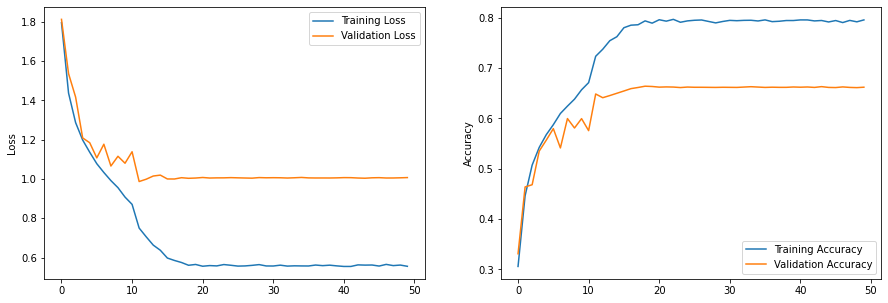

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.plot(process.history['loss'], label='Training Loss')
plt.plot(process.history['val_loss'], label='Validation Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy')
plt.plot(process.history['accuracy'], label='Training Accuracy')
plt.plot(process.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='best')
plt.show()


In [ ]:
model.load_weights("./model.cnn")

In [ ]:
Y_pred = model.predict(val, no_of_classes // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = ['angry', 'disgust', 'fear','happy','neutral','sad','suprise']
print(classification_report(val.classes, y_pred, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.12      0.13       960
     disgust       0.01      0.01      0.01       111
        fear       0.16      0.12      0.14      1018
       happy       0.26      0.27      0.26      1825
     neutral       0.15      0.18      0.16      1216
         sad       0.15      0.17      0.16      1139
     suprise       0.11      0.11      0.11       797

    accuracy                           0.17      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.17      0.17      0.17      7066



In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

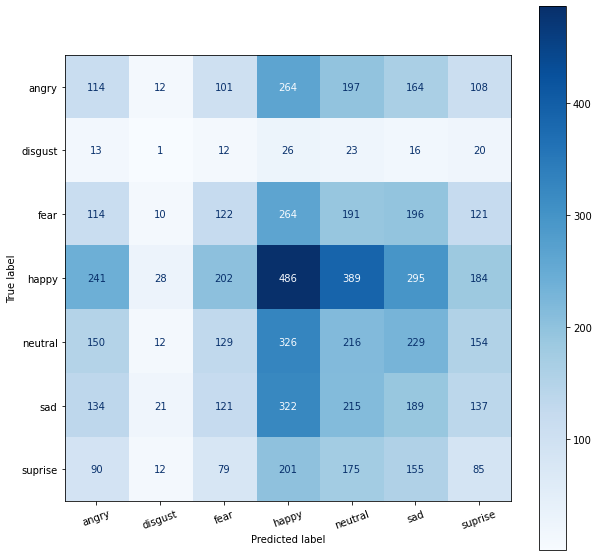

In [ ]:
plot_confusion_matrix(val.classes, y_pred, target_names)